In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.split = split
        
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        # self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        composition = 'Unknown'
        echogenicity = 'Unknown'
        margin = 'Unknown'
        calcification = 'Unknown'
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                #self.compositions[composition]
                # labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                # labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                # labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                # labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        # labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        
        #im = im * mask
        
        # Adding data augmentation to avoid overfitting
        if self.split == 'train':
            if random.randint(1, 10) > 5:
                im = np.flipud(im)
                mask = np.flipud(mask)
            if random.randint(1, 10) > 5:
                im = np.fliplr(im)
                mask = np.fliplr(mask)
            if random.randint(1, 10) > 5:
                for i in range(random.randint(1, 4)):
                    im = np.rot90(im)
                    mask = np.rot90(mask)
        im = np.ascontiguousarray(im)
        mask = np.ascontiguousarray(mask)
        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        mask = mask[0]
        mask = torch.unsqueeze(mask,0)
        #print(mask.shape)
        masked_im = torch.cat((im, mask), 0)
        # masked_im = im * ((mask / 2) + 0.5)
        
        #print(masked_im)
        
        masked_im = masked_im.type(torch.cuda.FloatTensor)
        
        sample = {"image": masked_im, "comp": self.compositions[composition],
                  "echo": self.echogenicities[echogenicity],
                  "margin": self.margins[margin],
                  "calc": self.calcifications[calcification],
                  "types" : self.types[idx], "name": str(im_name)}
        return sample

In [4]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
#training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)
train_data = iter(training_generator).next()

/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73
/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73


In [5]:
# Model definition and creation

z = 7 # groups
a = 18
k = 5 # top k 
num_labels = 1
num_channels = 4

G = np.random.randn(z, a)
W = np.random.randn(z, num_labels)

# class MutualExclusivityLoss(nn.Module):
#     def __init__(self, num_classes, num_attrs):
#         super(MutualExclusivityLoss, self).__init__()
#         self.num_attrs = num_attrs
#         self.num_classes = num_classes
#     def forward(self, target, result):
#         target = 1.0 - target
#         me_loss = target.mul(result)
#         return torch.mean(me_loss)
        
   

class AttribNet(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        #self.conv1 = nn.Conv2d(num_channels, 16, 7)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(16, 32, 7)
        #self.conv3 = nn.Conv2d(32, 64, 7)
        #self.conv4 = nn.Conv2d(64, 128, 7)
        #self.conv5 = nn.Conv2d(128, 256,7)
        #self.GAP = nn.AdaptiveAvgPool2d((1,1))
        #self.fc3 = nn.Linear(256, num_classes)
        
        self.conv1 = nn.Conv2d(num_channels, 16, 7)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=2, dilation=2)
        self.conv3 = nn.Conv2d(32, 64, 7, stride=2, dilation=2)
        self.conv4 = nn.Conv2d(64, 128, 7, stride=2, dilation=2)
        self.conv5 = nn.Conv2d(128, 256,7, stride=1, dilation=2)
        self.conv6 = nn.Conv2d(256, 256,7, dilation=2, padding='same')
        self.conv7 = nn.Conv2d(256, 256,7, dilation=2, padding='same')
        self.conv8 = nn.Conv2d(256, 256,7, dilation=2, padding='same')
        self.conv9 = nn.Conv2d(256, 256,7, dilation=2, padding='same')
        self.conv10 = nn.Conv2d(256, 256,7, dilation=2, padding='same')
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
            
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # Adding 1 more conv, a GAP and a final linear layer for CAM
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        features = x
        x = self.GAP(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc3(x)
        # x = torch.unsqueeze(x, 2)
        
        return (x, features)
    
class TypeNet(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.comp_model = AttribNet(5)
        self.echo_model = AttribNet(5)
        self.margin_model = AttribNet(5)
        self.calc_model = AttribNet(3)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        y_comp, comp_features = self.comp_model(x)
        y_echo, echo_features = self.echo_model(x)
        y_margin, margin_features = self.margin_model(x)
        y_calc, calc_features = self.calc_model(x)
        y_comp_s = F.softmax(y_comp)
        y_echo_s = F.softmax(y_echo)
        y_margin_s = F.softmax(y_margin)
        y_calc_s = F.softmax(y_calc)
        
        attribs = torch.cat((y_comp_s, y_echo_s, y_margin_s, y_calc_s), 1)
        #print(attribs.shape)
        features = torch.cat((comp_features, echo_features, margin_features, calc_features), 1)
        g = torch.matmul(self.G_, attribs.reshape((-1, a, 1))) 
        #print(g.shape, self.G_.shape)
        g = g.repeat((1, 1, num_labels))
        
        y = g * self.W_
        #print(y.shape)
        #y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        return (y_comp, y_echo, y_margin, y_calc, torch.sigmoid(y), features)

# Model creation and definition of losses
model = TypeNet(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)

def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

criterion = torch.nn.CrossEntropyLoss(reduction='mean')

criterion1 = torch.nn.L1Loss(reduction='sum')

#criterion2 = MutualExclusivityLoss(15, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)

In [7]:
# Load existing model
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2_CAM_3_weighted_mask.pt'))

RuntimeError: Error(s) in loading state_dict for TypeNet:
	Missing key(s) in state_dict: "comp_model.conv1.weight", "comp_model.conv1.bias", "comp_model.conv2.weight", "comp_model.conv2.bias", "comp_model.conv3.weight", "comp_model.conv3.bias", "comp_model.conv4.weight", "comp_model.conv4.bias", "comp_model.conv5.weight", "comp_model.conv5.bias", "comp_model.fc3.weight", "comp_model.fc3.bias", "echo_model.conv1.weight", "echo_model.conv1.bias", "echo_model.conv2.weight", "echo_model.conv2.bias", "echo_model.conv3.weight", "echo_model.conv3.bias", "echo_model.conv4.weight", "echo_model.conv4.bias", "echo_model.conv5.weight", "echo_model.conv5.bias", "echo_model.fc3.weight", "echo_model.fc3.bias", "calc_model.conv1.weight", "calc_model.conv1.bias", "calc_model.conv2.weight", "calc_model.conv2.bias", "calc_model.conv3.weight", "calc_model.conv3.bias", "calc_model.conv4.weight", "calc_model.conv4.bias", "calc_model.conv5.weight", "calc_model.conv5.bias", "calc_model.fc3.weight", "calc_model.fc3.bias", "margin_model.conv1.weight", "margin_model.conv1.bias", "margin_model.conv2.weight", "margin_model.conv2.bias", "margin_model.conv3.weight", "margin_model.conv3.bias", "margin_model.conv4.weight", "margin_model.conv4.bias", "margin_model.conv5.weight", "margin_model.conv5.bias", "margin_model.fc3.weight", "margin_model.fc3.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "conv5.weight", "conv5.bias", "fc3.weight", "fc3.bias". 

In [6]:
# perform training

epoch = 0
for epoch in range(2000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["types"].to(device)
        x_im_train = x_im_train.to(device)
        
        y_comp = data["comp"].to(device)
        y_echo = data["echo"].to(device)
        y_margin = data["margin"].to(device)
        y_calc = data["calc"].to(device)
        
        optimizer.zero_grad()

        (pred_comp, pred_echo, pred_margin, pred_calc, y_pred, features) = model(x_im_train)
        # this needs work 
        loss = criterion(pred_comp, y_comp) + criterion(pred_echo, y_echo) + criterion(pred_margin, y_margin) + criterion(pred_calc, y_calc) 
        # criterion1(y_pred.to(float), y_im_train.to(float))
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch:  1 ; running-loss:  53.171260833740234
Epoch:  2 ; running-loss:  52.99465227127075
Epoch:  3 ; running-loss:  52.21372842788696
Epoch:  4 ; running-loss:  46.58442974090576
Epoch:  5 ; running-loss:  40.37054944038391
Epoch:  6 ; running-loss:  38.58224439620972
Epoch:  7 ; running-loss:  38.19054460525513
Epoch:  8 ; running-loss:  37.54976296424866
Epoch:  9 ; running-loss:  37.96834754943848
Epoch:  10 ; running-loss:  37.773517370224
Epoch:  11 ; running-loss:  37.67289900779724
Epoch:  12 ; running-loss:  37.59962034225464
Epoch:  13 ; running-loss:  37.36952042579651
Epoch:  14 ; running-loss:  37.4891083240509
Epoch:  15 ; running-loss:  37.45126271247864
Epoch:  16 ; running-loss:  37.27863883972168
Epoch:  17 ; running-loss:  37.27816462516785
Epoch:  18 ; running-loss:  37.20015001296997
Epoch:  19 ; running-loss:  37.37684226036072
Epoch:  20 ; running-loss:  37.491193771362305
Epoch:  21 ; running-loss:  37.193089723587036
Epoch:  22 ; running-loss:  37.290056943893

Epoch:  177 ; running-loss:  32.27399444580078
Epoch:  178 ; running-loss:  32.51559376716614
Epoch:  179 ; running-loss:  31.911617517471313
Epoch:  180 ; running-loss:  31.868118047714233
Epoch:  181 ; running-loss:  31.068085193634033
Epoch:  182 ; running-loss:  31.805768728256226
Epoch:  183 ; running-loss:  30.90949821472168
Epoch:  184 ; running-loss:  30.929723739624023
Epoch:  185 ; running-loss:  32.41597056388855
Epoch:  186 ; running-loss:  33.17505240440369
Epoch:  187 ; running-loss:  30.976949453353882
Epoch:  188 ; running-loss:  32.07329201698303
Epoch:  189 ; running-loss:  31.77155113220215
Epoch:  190 ; running-loss:  31.128044366836548
Epoch:  191 ; running-loss:  31.286099910736084
Epoch:  192 ; running-loss:  30.364248752593994
Epoch:  193 ; running-loss:  30.817423105239868
Epoch:  194 ; running-loss:  31.19646406173706
Epoch:  195 ; running-loss:  31.179712295532227
Epoch:  196 ; running-loss:  31.414425373077393
Epoch:  197 ; running-loss:  30.647587776184082


Epoch:  349 ; running-loss:  23.371898651123047
Epoch:  350 ; running-loss:  22.34004819393158
Epoch:  351 ; running-loss:  21.781468629837036
Epoch:  352 ; running-loss:  21.91255033016205
Epoch:  353 ; running-loss:  21.862186670303345
Epoch:  354 ; running-loss:  22.404305696487427
Epoch:  355 ; running-loss:  21.518126726150513
Epoch:  356 ; running-loss:  20.568098187446594
Epoch:  357 ; running-loss:  20.337664365768433
Epoch:  358 ; running-loss:  21.78353476524353
Epoch:  359 ; running-loss:  24.201586723327637
Epoch:  360 ; running-loss:  24.37106227874756
Epoch:  361 ; running-loss:  21.6934711933136
Epoch:  362 ; running-loss:  21.44785761833191
Epoch:  363 ; running-loss:  21.772615432739258
Epoch:  364 ; running-loss:  21.69364356994629
Epoch:  365 ; running-loss:  20.603737950325012
Epoch:  366 ; running-loss:  22.278409123420715
Epoch:  367 ; running-loss:  23.065829634666443
Epoch:  368 ; running-loss:  22.397865056991577
Epoch:  369 ; running-loss:  23.156490087509155


Epoch:  522 ; running-loss:  14.583364605903625
Epoch:  523 ; running-loss:  13.931623458862305
Epoch:  524 ; running-loss:  13.160083055496216
Epoch:  525 ; running-loss:  14.228641152381897
Epoch:  526 ; running-loss:  12.322221159934998
Epoch:  527 ; running-loss:  12.041186571121216
Epoch:  528 ; running-loss:  11.745908558368683
Epoch:  529 ; running-loss:  11.481711208820343
Epoch:  530 ; running-loss:  12.061526894569397
Epoch:  531 ; running-loss:  13.128890037536621
Epoch:  532 ; running-loss:  12.261934101581573
Epoch:  533 ; running-loss:  14.660775542259216
Epoch:  534 ; running-loss:  13.871463418006897
Epoch:  535 ; running-loss:  13.29378080368042
Epoch:  536 ; running-loss:  12.699852287769318
Epoch:  537 ; running-loss:  12.525716662406921
Epoch:  538 ; running-loss:  10.554041743278503
Epoch:  539 ; running-loss:  9.953084945678711
Epoch:  540 ; running-loss:  10.831892251968384
Epoch:  541 ; running-loss:  9.259258925914764
Epoch:  542 ; running-loss:  9.884075194597

Epoch:  696 ; running-loss:  7.178311914205551
Epoch:  697 ; running-loss:  6.6380815505981445
Epoch:  698 ; running-loss:  12.154491066932678
Epoch:  699 ; running-loss:  14.814951181411743
Epoch:  700 ; running-loss:  12.19937378168106
Epoch:  701 ; running-loss:  16.116751313209534
Epoch:  702 ; running-loss:  9.787953495979309
Epoch:  703 ; running-loss:  9.592367053031921
Epoch:  704 ; running-loss:  7.211348086595535
Epoch:  705 ; running-loss:  7.6940189599990845
Epoch:  706 ; running-loss:  7.504633605480194
Epoch:  707 ; running-loss:  5.843228667974472
Epoch:  708 ; running-loss:  5.0271715223789215
Epoch:  709 ; running-loss:  5.385780602693558
Epoch:  710 ; running-loss:  13.076466262340546
Epoch:  711 ; running-loss:  6.350139319896698
Epoch:  712 ; running-loss:  6.518826454877853
Epoch:  713 ; running-loss:  9.1983080804348
Epoch:  714 ; running-loss:  5.956831470131874
Epoch:  715 ; running-loss:  6.543057501316071
Epoch:  716 ; running-loss:  5.978026181459427
Epoch:  

Epoch:  869 ; running-loss:  5.024292349815369
Epoch:  870 ; running-loss:  4.072380512952805
Epoch:  871 ; running-loss:  4.100393205881119
Epoch:  872 ; running-loss:  4.208025902509689
Epoch:  873 ; running-loss:  3.607864275574684
Epoch:  874 ; running-loss:  3.4863577634096146
Epoch:  875 ; running-loss:  3.3936157524585724
Epoch:  876 ; running-loss:  3.3305618315935135
Epoch:  877 ; running-loss:  2.3205493465065956
Epoch:  878 ; running-loss:  2.4765378832817078
Epoch:  879 ; running-loss:  1.7372353821992874
Epoch:  880 ; running-loss:  2.677650071680546
Epoch:  881 ; running-loss:  3.2286325618624687
Epoch:  882 ; running-loss:  2.5248732790350914
Epoch:  883 ; running-loss:  2.0581019409000874
Epoch:  884 ; running-loss:  1.9942901879549026
Epoch:  885 ; running-loss:  1.7351932860910892
Epoch:  886 ; running-loss:  1.9284143149852753
Epoch:  887 ; running-loss:  1.913138274103403
Epoch:  888 ; running-loss:  1.356304595246911
Epoch:  889 ; running-loss:  1.300251392647624
E

Epoch:  1041 ; running-loss:  1.1293671587482095
Epoch:  1042 ; running-loss:  1.1233403868973255
Epoch:  1043 ; running-loss:  1.1216292195022106
Epoch:  1044 ; running-loss:  2.0021522557362914
Epoch:  1045 ; running-loss:  1.8695550439879298
Epoch:  1046 ; running-loss:  1.841487281024456
Epoch:  1047 ; running-loss:  1.185309899970889
Epoch:  1048 ; running-loss:  1.6878469595685601
Epoch:  1049 ; running-loss:  1.0238471664488316
Epoch:  1050 ; running-loss:  0.8092977944761515
Epoch:  1051 ; running-loss:  0.9170290902256966
Epoch:  1052 ; running-loss:  0.5148039776831865
Epoch:  1053 ; running-loss:  0.5814926940947771
Epoch:  1054 ; running-loss:  0.714899942278862
Epoch:  1055 ; running-loss:  0.5827085822820663
Epoch:  1056 ; running-loss:  0.6523852832615376
Epoch:  1057 ; running-loss:  0.40794005431234837
Epoch:  1058 ; running-loss:  0.53080162871629
Epoch:  1059 ; running-loss:  0.851287045981735
Epoch:  1060 ; running-loss:  0.658948905300349
Epoch:  1061 ; running-los

Epoch:  1209 ; running-loss:  0.22918643639422953
Epoch:  1210 ; running-loss:  0.18914265232160687
Epoch:  1211 ; running-loss:  0.12680780328810215
Epoch:  1212 ; running-loss:  0.1808687043376267
Epoch:  1213 ; running-loss:  0.11371038015931845
Epoch:  1214 ; running-loss:  0.14028854458592832
Epoch:  1215 ; running-loss:  0.15012078639119864
Epoch:  1216 ; running-loss:  0.14848645858000964
Epoch:  1217 ; running-loss:  0.21448200149461627
Epoch:  1218 ; running-loss:  0.17765103420242667
Epoch:  1219 ; running-loss:  0.15494061505887657
Epoch:  1220 ; running-loss:  0.13770571607165039
Epoch:  1221 ; running-loss:  0.10438641731161624
Epoch:  1222 ; running-loss:  0.09751436195801944
Epoch:  1223 ; running-loss:  0.0941285704029724
Epoch:  1224 ; running-loss:  0.10635172680485994
Epoch:  1225 ; running-loss:  0.08621708722785115
Epoch:  1226 ; running-loss:  0.10957374284043908
Epoch:  1227 ; running-loss:  0.10831730125937611
Epoch:  1228 ; running-loss:  0.07032877090387046
Ep

Epoch:  1373 ; running-loss:  0.01787874914589338
Epoch:  1374 ; running-loss:  0.008827380079310387
Epoch:  1375 ; running-loss:  0.008247286779806018
Epoch:  1376 ; running-loss:  0.012757499178405851
Epoch:  1377 ; running-loss:  0.012173135561170056
Epoch:  1378 ; running-loss:  0.008333821737323888
Epoch:  1379 ; running-loss:  0.023802303709089756
Epoch:  1380 ; running-loss:  0.016181849321583286
Epoch:  1381 ; running-loss:  0.014189367822837085
Epoch:  1382 ; running-loss:  0.008022581590921618
Epoch:  1383 ; running-loss:  0.011776706523960456
Epoch:  1384 ; running-loss:  0.008883889691787772
Epoch:  1385 ; running-loss:  0.008463089485303499
Epoch:  1386 ; running-loss:  0.009559099446050823
Epoch:  1387 ; running-loss:  0.021293471902026795
Epoch:  1388 ; running-loss:  0.019885750953108072
Epoch:  1389 ; running-loss:  0.014076234336243942
Epoch:  1390 ; running-loss:  0.0060864773113280535
Epoch:  1391 ; running-loss:  0.011414796506869607
Epoch:  1392 ; running-loss:  0

Epoch:  1534 ; running-loss:  0.0025106282555498183
Epoch:  1535 ; running-loss:  0.002578776780865155
Epoch:  1536 ; running-loss:  0.002308156283106655
Epoch:  1537 ; running-loss:  0.002118064890964888
Epoch:  1538 ; running-loss:  0.0020886129423161037
Epoch:  1539 ; running-loss:  0.00220097613055259
Epoch:  1540 ; running-loss:  0.007361572170339059
Epoch:  1541 ; running-loss:  0.00266553093388211
Epoch:  1542 ; running-loss:  0.002702842339203926
Epoch:  1543 ; running-loss:  0.003105633415543707
Epoch:  1544 ; running-loss:  0.0020496141696639825
Epoch:  1545 ; running-loss:  0.0025949604514607927
Epoch:  1546 ; running-loss:  0.0022597498827963136
Epoch:  1547 ; running-loss:  0.002267037423735019
Epoch:  1548 ; running-loss:  0.001885124933323823
Epoch:  1549 ; running-loss:  0.004315640337154036
Epoch:  1550 ; running-loss:  0.0019276246421213727
Epoch:  1551 ; running-loss:  0.0030094230169197544
Epoch:  1552 ; running-loss:  0.0012148113164585084
Epoch:  1553 ; running-lo

Epoch:  1693 ; running-loss:  0.00045135343225410907
Epoch:  1694 ; running-loss:  0.000996996237518033
Epoch:  1695 ; running-loss:  0.001388635018884088
Epoch:  1696 ; running-loss:  0.0005603054842140409
Epoch:  1697 ; running-loss:  0.0009230939253939141
Epoch:  1698 ; running-loss:  0.0006322886492853286
Epoch:  1699 ; running-loss:  0.0008538210113329114
Epoch:  1700 ; running-loss:  0.001284820538785425
Epoch:  1701 ; running-loss:  0.0006086037792556453
Epoch:  1702 ; running-loss:  0.0008515998470102204
Epoch:  1703 ; running-loss:  0.0007161503781389911
Epoch:  1704 ; running-loss:  0.0005324086769178393
Epoch:  1705 ; running-loss:  0.000712135436515382
Epoch:  1706 ; running-loss:  0.001172617570773582
Epoch:  1707 ; running-loss:  0.0011551999123184942
Epoch:  1708 ; running-loss:  0.0007703200772084529
Epoch:  1709 ; running-loss:  0.0006940333078091498
Epoch:  1710 ; running-loss:  0.0007013427857600618
Epoch:  1711 ; running-loss:  0.0005257866177998949
Epoch:  1712 ; r

Epoch:  1851 ; running-loss:  0.0002646056204866909
Epoch:  1852 ; running-loss:  0.00028312541553532355
Epoch:  1853 ; running-loss:  0.0004702450269178371
Epoch:  1854 ; running-loss:  0.00029841183277312666
Epoch:  1855 ; running-loss:  0.0003588687577575911
Epoch:  1856 ; running-loss:  0.0005351517011149554
Epoch:  1857 ; running-loss:  0.0002829820259648841
Epoch:  1858 ; running-loss:  0.000363886898412602
Epoch:  1859 ; running-loss:  0.00033528238145663636
Epoch:  1860 ; running-loss:  0.0002841978639480658
Epoch:  1861 ; running-loss:  0.00031420200275533716
Epoch:  1862 ; running-loss:  0.0004191553321106767
Epoch:  1863 ; running-loss:  0.00021828050466865534
Epoch:  1864 ; running-loss:  0.00032765138985269004
Epoch:  1865 ; running-loss:  0.00029770170476695057
Epoch:  1866 ; running-loss:  0.00047303184101110674
Epoch:  1867 ; running-loss:  0.00038132151007630455
Epoch:  1868 ; running-loss:  0.00030488866059386055
Epoch:  1869 ; running-loss:  0.00034599027367221424
Ep

In [6]:
# save the trainined model

torch.save(model.state_dict(), f'../data/models/end_to_end_v2_CAM_3_weighted_mask_new_separate_CNN.pt')

/home/ahana/thyroid/data/test/benign
/home/ahana/thyroid/data/test/malign
number of data items:25


Image number: 0


/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Top_k z: [1.81503954 2.77705074 2.97862749 2.88041426 1.97220687]
Top_k W: [ 0.93241333  0.83476237 -0.61017527 -0.32688414 -0.76728485]
Y matrix [ 1.69236707  2.31817747 -1.81748484 -0.94156173 -1.51324445]
Y pred -0.2617464796265516 [[0.39967936]]
256 256


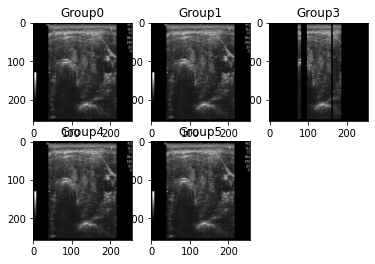



Image number: 1


Top_k z: [2.52280866 2.43749331 2.04705355 2.48452419 3.5976552 ]
Top_k W: [ 0.83476237  0.52446054 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 2.10594574  1.27836906 -0.66914933 -1.90633776  3.44353342]
Y pred 4.252361133211073 [[0.8239619]]
256 256


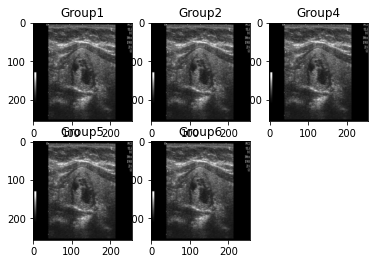



Image number: 2


Top_k z: [1.057881   1.22193291 2.44950719 0.78947096 4.98251677]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 0.88307925  0.64085559 -1.49462872 -0.6057491   4.7690682 ]
Y pred 4.192625230504278 [[0.5233986]]
256 256


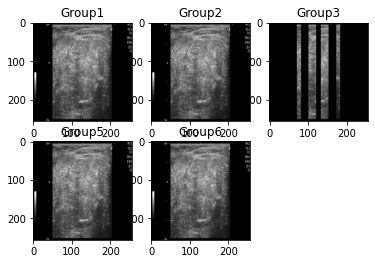



Image number: 3


Top_k z: [1.13321883 0.79232646 1.2219329  1.39785621 5.45133075]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 1.05662835  0.66140432  0.64085559 -0.85293729  5.21779842]
Y pred 6.723749389299938 [[0.740933]]
256 256


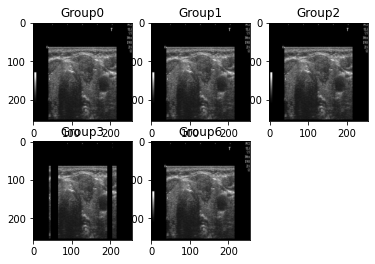



Image number: 4


Top_k z: [1.45738535 2.04464648 1.53930457 2.01445036 5.65496686]
Top_k W: [ 0.93241333  0.83476237 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 1.35888553  1.70679395 -0.50317425 -1.54565724  5.41271086]
Y pred 6.429558859448316 [[0.78484046]]
256 256


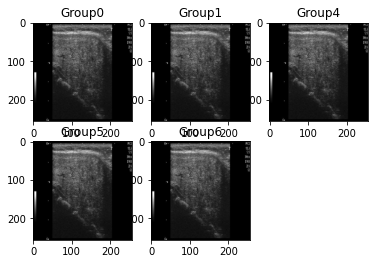



Image number: 5


Top_k z: [2.05706122 3.98731403 1.9082628  1.53761297 4.20477749]
Top_k W: [ 0.83476237 -0.61017527 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 1.71715731 -2.43296042 -0.62378084 -1.17978713  4.02464689]
Y pred 1.505275815897022 [[0.34246203]]
256 256


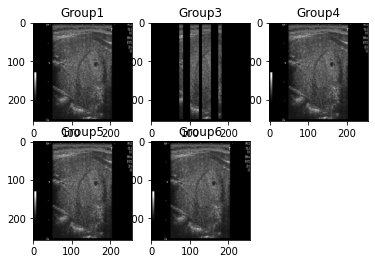



Image number: 6


Top_k z: [1.05788409 1.22193133 2.44950398 0.78947444 4.98251077]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 0.88308183  0.64085477 -1.49462675 -0.60575177  4.76906246]
Y pred 4.192620531550714 [[0.5233988]]
256 256


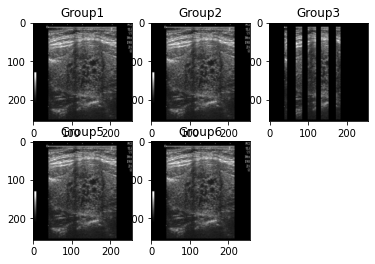



Image number: 7


Top_k z: [1.86766746 2.72128929 1.6883195  1.4262629  4.9668891 ]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 1.55905852  1.42720885 -1.03017081 -1.09434991  4.75411002]
Y pred 5.615856665847739 [[0.7871761]]
256 256


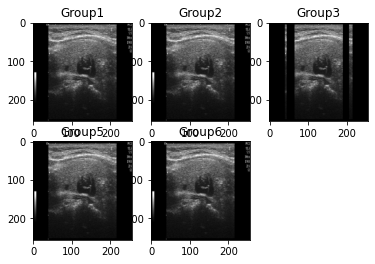



Image number: 8


Top_k z: [2.21466906 2.78793478 1.61427399 1.19043176 4.36067742]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.76728485  0.95716049]
Y matrix [ 2.06498696  2.32726305  0.84662301 -0.91340025  4.17386815]
Y pred 8.499340929331797 [[0.86197484]]
256 256


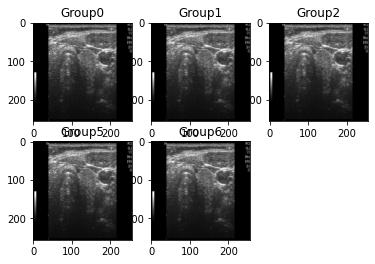



Image number: 9


Top_k z: [2.90832746 2.7793312  2.71809372 2.66113596 2.87892753]
Top_k W: [ 0.83476237 -0.61017527 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 2.42776233 -1.69587917 -0.88850172 -2.0418493   2.75559569]
Y pred 0.557127840742996 [[0.42365178]]
256 256


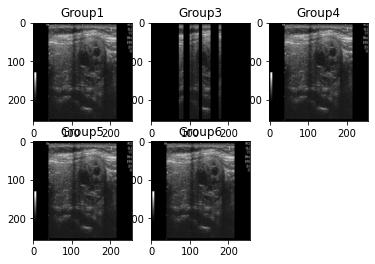



Image number: 10


Top_k z: [2.54048308 2.46622917 2.06942126 2.51098493 3.54427584]
Top_k W: [ 0.83476237  0.52446054 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 2.12069969  1.29343989 -0.67646098 -1.92664069  3.3924408 ]
Y pred 4.203478707246523 [[0.8248598]]
256 256


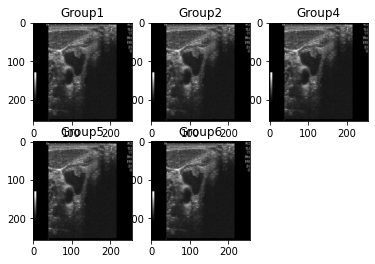



Image number: 11


Top_k z: [1.13321883 0.79232646 1.22193297 1.39785626 5.45133074]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 1.05662835  0.66140432  0.64085562 -0.85293732  5.21779842]
Y pred 6.723749382207318 [[0.740933]]
256 256


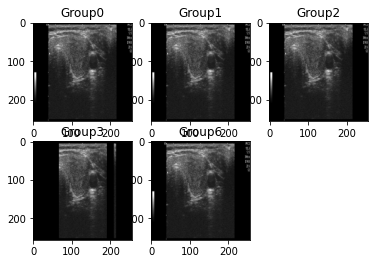



Image number: 12


Top_k z: [1.14277061 2.15373344 1.39382157 1.32611932 4.4407758 ]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 1.06553455  1.79785564  0.73100442 -0.80916521  4.25053515]
Y pred 7.03576454694614 [[0.80563116]]
256 256


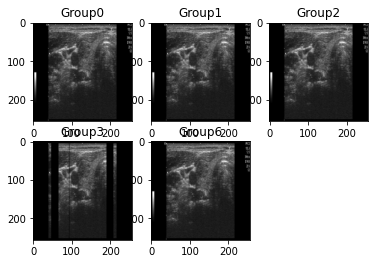



Image number: 13


Top_k z: [1.64842051 1.94111416 2.14109099 2.33573254 3.47182277]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 1.53700926  1.62036907  1.12291774 -1.42520623  3.32309159]
Y pred 6.178181422360968 [[0.6667871]]
256 256


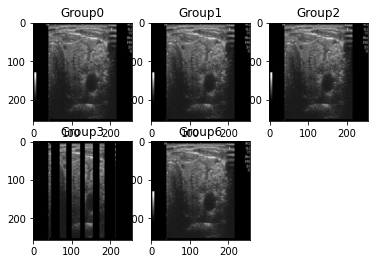



Image number: 14


Top_k z: [1.54312412 1.70316647 1.29287937 1.27539716 5.9850536 ]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 1.28814196  0.89324361 -0.78888302 -0.97859292  5.72865685]
Y pred 6.142566484855701 [[0.7196977]]
256 256


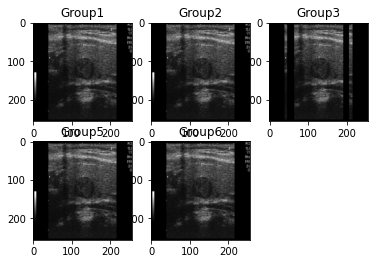



Image number: 15


Top_k z: [0.85222993 1.00118946 1.2221328  1.40332334 6.73499698]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 0.79463055  0.83575529  0.64096043 -0.8562732   6.44647302]
Y pred 7.861546085341889 [[0.74091095]]
256 256


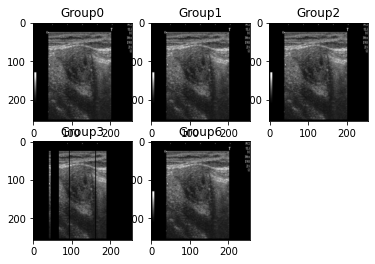



Image number: 16


Top_k z: [1.81503954 1.77909194 1.51835731 1.22497941 4.0200063 ]
Top_k W: [ 0.93241333  0.83476237 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 1.69236707  1.48511901 -0.49632692 -0.93990814  3.8477912 ]
Y pred 5.589042225389512 [[0.7848409]]
256 256


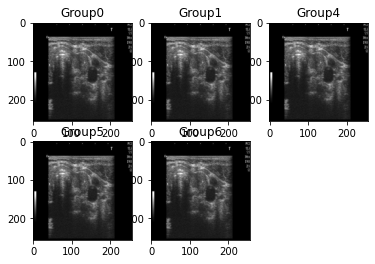



Image number: 17


Top_k z: [3.04038664 2.99135745 2.89956096 2.75832114 2.77844691]
Top_k W: [ 0.83476237 -0.61017527 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 2.53800037 -1.82525234 -0.94782048 -2.11641801  2.65941961]
Y pred 0.30792914646862135 [[0.3989386]]
256 256


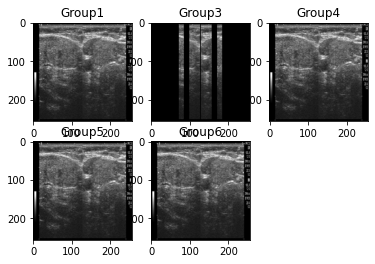



Image number: 18


Top_k z: [1.81503925 4.65476678 2.69107815 3.6763589  2.80646439]
Top_k W: [ 0.93241333  0.83476237 -0.61017527 -0.32688414 -0.76728485]
Y matrix [ 1.69236679  3.88562417 -1.64202934 -1.20174341 -2.1533576 ]
Y pred 0.5808606162535837 [[0.4896579]]
256 256


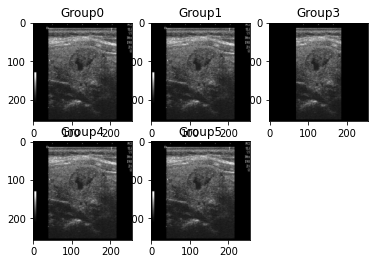



Image number: 19


Top_k z: [1.90578996 2.54118724 2.07017878 2.51165271 2.42418577]
Top_k W: [ 0.93241333  0.83476237 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 1.77698396  2.12128749 -0.6767086  -1.92715307  2.32033484]
Y pred 3.614744627291561 [[0.55639225]]
256 256


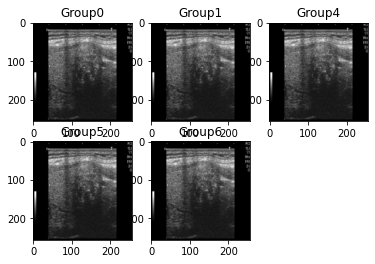



Image number: 20


Top_k z: [1.55507134 1.71533269 1.29026685 1.28349084 5.95699729]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 1.29811505  0.89962431 -0.78728893 -0.98480307  5.70180246]
Y pred 6.127449819146115 [[0.71947634]]
256 256


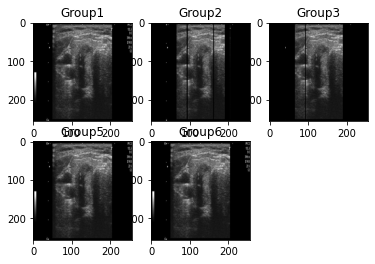



Image number: 21


Top_k z: [1.1332206  2.66168312 1.10820851 1.31487542 4.46432541]
Top_k W: [ 0.93241333  0.83476237 -0.61017527 -0.32688414  0.95716049]
Y matrix [ 1.05662999  2.22187292 -0.67620143 -0.42981192  4.27307591]
Y pred 6.445565472868339 [[0.80487764]]
256 256


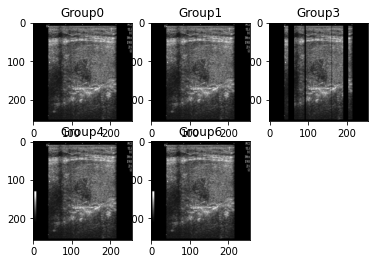



Image number: 22


Top_k z: [1.05999715 1.22088881 1.40175678 0.79198611 7.08268148]
Top_k W: [ 0.83476237  0.52446054 -0.61017527 -0.76728485  0.95716049]
Y matrix [ 0.88484574  0.64030801 -0.85531732 -0.60767894  6.77926289]
Y pred 6.841420372372233 [[0.74103504]]
256 256


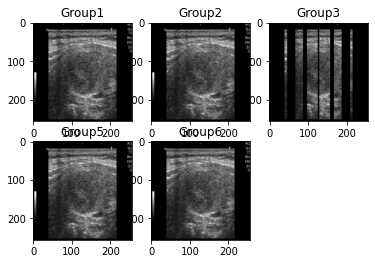



Image number: 23


Top_k z: [2.05677661 3.98725834 1.9082156  1.53680962 4.20319872]
Top_k W: [ 0.83476237 -0.61017527 -0.32688414 -0.76728485  0.95716049]
Y matrix [ 1.71691972 -2.43292644 -0.62376541 -1.17917074  4.02313575]
Y pred 1.504192891457449 [[0.34246615]]
256 256


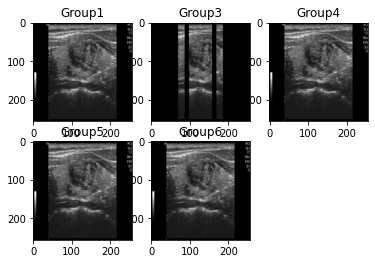



Image number: 24


Top_k z: [1.63327495 1.92600386 2.12423778 1.29148525 5.60153308]
Top_k W: [ 0.93241333  0.83476237  0.52446054 -0.61017527  0.95716049]
Y matrix [ 1.52288734  1.60775556  1.11407889 -0.78803236  5.36156616]
Y pred 8.818255585075391 [[0.8375563]]
256 256


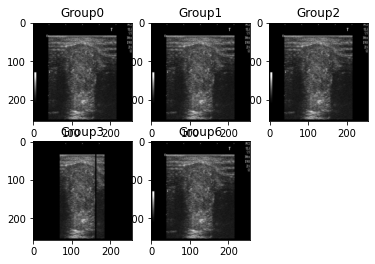

In [96]:
## Run tests and save CAM images in folder "heatmaps" on test data
def returnCAM(feature_conv, weight_linear, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_linear[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        if (np.max(cam)) != 0:
            cam_img = cam / (np.max(cam))
        else:
            cam_img = cam
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
        
    return output_cam

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}

# Saving the parameters from each attribute model
comp_params = list(model.comp_model.parameters())
echo_params = list(model.echo_model.parameters())
margin_params = list(model.margin_model.parameters())
calc_params = list(model.calc_model.parameters())

# Fetching weights of the linear layer for each model
weight_comp_linear = np.squeeze(comp_params[-2].data.cpu().numpy())
weight_echo_linear = np.squeeze(echo_params[-2].data.cpu().numpy())
weight_margin_linear = np.squeeze(margin_params[-2].data.cpu().numpy())
weight_calc_linear = np.squeeze(calc_params[-2].data.cpu().numpy())


test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

# Setting colors for the Sankey plots
color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', 
              '#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B'
              ]

color_link = []
link_colors = ['#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B']
for i in range(k):
        color_link.extend([link_colors[i]] * a)
        
# Starting the prediction loop
count = 0
for (index, data) in enumerate(test_generator):
    # Get the ground ruths for each attribute and final type
    y_comp = data["comp"].to(device)
    y_echo = data["echo"].to(device)
    y_calc = data["calc"].to(device)
    y_margin = data["margin"].to(device)
    x_im_test = data["image"]
    y_im_test = data["types"].to(device)
    x_im_test = x_im_test.to(device)
    
    # Get the predictions and th efeatures from the model
    (pred_comp, pred_echo, pred_margin, pred_calc, y_pred, features) = model(x_im_test)
    features_comp = features[:,:256,:,:]
    features_echo = features[:,256:512,:,:]
    features_margin = features[:,512:768,:,:]
    features_calc = features[:,768:1024,:,:]
    
    # Using softmax on the sttribute values to get probabilities
    # Using argmax to get the predicted class
    pred_comp = nn.functional.softmax(pred_comp, dim=1).detach().cpu().numpy()
    #print(pred_comp)
    pred_comp1 = np.argmax(pred_comp, axis=1)
    pred_echo = nn.functional.softmax(pred_echo, dim=1).detach().cpu().numpy()
    pred_echo1 = np.argmax(pred_echo, axis=1)
    pred_calc = nn.functional.softmax(pred_calc, dim=1).detach().cpu().numpy() 
    pred_calc1 = np.argmax(pred_calc, axis=1)
    pred_margin = nn.functional.softmax(pred_margin, dim=1).detach().cpu().numpy()
    pred_margin1 = np.argmax(pred_margin, axis=1)
    
    # Combining the probabilities and predictions from the separate attribute classification problems
    attr_probs = np.concatenate((pred_comp, pred_echo, pred_margin, pred_calc), axis = None)
    attributes_pred = [pred_comp1, pred_echo1, pred_margin1, pred_calc1]
    attr_pred.append(np.asarray(attributes_pred))
    attributes = [y_comp.detach().cpu().numpy(), y_echo.detach().cpu().numpy(), y_margin.detach().cpu().numpy(), y_calc.detach().cpu().numpy()]
    attr_gt.append(np.asarray(attributes))
    
    # Finding and using top-K for the Sankey plots
    group_attr = np.matmul(G, attr_probs)
    top_k = np.argpartition(group_attr, -k)[-k:]
    top_k = np.sort(top_k)
    top_G = group_attr[top_k]
    #top_probs = attr_probs[top_k]
    
    print("\n\nImage number:", index)
    #Sankey plot code source and target
    source = [i % a for i in range(k*a)]
    target = [(i // a) + a for i in range(k*a)]
    #G[G < 0.1] = 0.0
    # Select the top-k rows from G matrix
    top_G_rows = G[top_k]
    # top_G_rows_norm = top_G_rows / np.amax(top_G_rows, axis=1).reshape((k,1))
    #print(np.amax(top_G_rows, axis=1))
    #print(top_G_rows)
    # top_G_rows[top_G_rows_norm < 0.4] = 0
    value = top_G_rows.flatten().tolist()
    
    #print(len(source), len(target), len(value))
    
    #print(color_link)
    
    # Labels to show the respective attribute probability as well
    base_labels = ["unknown comp", "cystic", "mostly solid", "solid", "spongiform",
                   "unknown echo", "hyper", "hypo", "iso", "marked",
                   "unknown margin", "ill-defined", "micro", "spiculated", "smooth",
                   "macro", "micro", "non"]
    labels = []
    for i, prob in enumerate(attr_probs.tolist()):
        prob_str = '{:.2f}'.format(prob)
        labels.append(base_labels[i] + " " + "(" + prob_str + ")")
    for group in top_k.tolist():
        labels.append("G"+str(group))
        
    #print(labels)
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          color = color_node,
          label = labels,
        ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
      ))])
    fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
    fig.show()

    # End of Sankey plot generation
    
    # Code to show the values of z (G*a), W, Y and summed up Y
    # FIXME: The model does not use the top-k groups to compute Y
    print("Top_k z:", top_G)
    top_W = W[top_k].reshape(-1)
    print("Top_k W:", top_W)
    y_vals = np.multiply(top_G, top_W)
    print("Y matrix", y_vals)
    y_sum = np.sum(y_vals)
    # Print the summe dup Y and th eone we get from model (model also uses sigmoid)
    print("Y pred", y_sum, y_pred.detach().cpu().numpy())
    #attr_gt.append(data["types"].detach().cpu().numpy())  
    attrib_list = [i for i in range(0, 5)]
    
    # Save a thresholded activation map for each group
    CAMs = returnCAM(features_comp.detach().cpu().numpy(), weight_comp_linear, attrib_list)
    img = data["image"][0][:3,:,:].cpu().permute(1, 2, 0).numpy()
    #img = data["image"][0].cpu().permute(1, 2, 0).numpy()
    #img = img * 5
    height, width, c = img.shape
    #result = img[:,:, 0]
    result = img
    heatmaps = []
    
    # Loop for composition attributes
    for i in range(0, 5):
        #heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        #result = img
        #heatmap = cv2.resize(CAMs[i],(width, height))
        heatmap = CAMs[i]
        heatmap = cv2.merge((heatmap, heatmap, heatmap))
        #heatmap = heatmap / np.max(heatmap)
        #heatmap[heatmap >= 0.5] = 1
        #heatmap[heatmap < 0.5] = 0
        heatmaps.append(heatmap)
        #result *= heatmap
        #plt.imshow(result)
       
    # Loop for echo attributes    
    attrib_list = [i for i in range(0, 5)]
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features_echo.detach().cpu().numpy(), weight_echo_linear, attrib_list)
    height, width, c = img.shape
    for i in range(0, 5):
        #heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        #result += heatmap * 0.1
        #heatmap = cv2.resize(CAMs[i],(width, height))
        heatmap = CAMs[i]
        heatmap = cv2.merge((heatmap, heatmap, heatmap))
        #heatmap = heatmap / np.max(heatmap)
        #heatmap[heatmap >= 0.5] = 1
        #heatmap[heatmap < 0.5] = 0
        heatmaps.append(heatmap)
        
    
    # # Loop for margin attributes    
    attrib_list = [i for i in range(0, 5)]
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features_margin.detach().cpu().numpy(), weight_margin_linear, attrib_list)
    height_h, width_h = CAMs[0].shape
    print(height_h, width_h)
    height, width, c = img.shape
    #result = img
    for i in range(0, 5):
        #heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        #result += heatmap * 0.1
        #heatmap = cv2.resize(CAMs[i],(width, height))
        heatmap = CAMs[i]
        heatmap = cv2.merge((heatmap, heatmap, heatmap))
        #heatmap = heatmap / np.max(heatmap)
        #heatmap[heatmap >= 0.5] = 1
        #heatmap[heatmap < 0.5] = 0
        heatmaps.append(heatmap)
      
    # # Loop for calc attributes 
    attrib_list = [i for i in range(0, 3)]
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features_calc.detach().cpu().numpy(), weight_calc_linear, attrib_list)
    height, width, c = img.shape
    for i in range(0, 3):
        #heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        #result += heatmap * 0.1
        #heatmap = cv2.resize(CAMs[i],(width, height))
        heatmap = CAMs[i]
        heatmap = cv2.merge((heatmap, heatmap, heatmap))
        #heatmap = heatmap / np.max(heatmap)
        
        #heatmap[heatmap >= 0.5] = 1
        #heatmap[heatmap < 0.5] = 0
        heatmaps.append(heatmap)
    
    # Compute activation of a group using attribute activation and top-k rows of G matrix
    group_activations = []
    for group in range(k):
        group_activations.append(np.zeros((height_h, width_h, c)))
        for (i, heatmap) in enumerate(heatmaps):
            #print(group, i)
            group_activations[group] += heatmap[i] * top_G_rows[group][i]
            
    
    # Plot group-wise activations for top-k groups
    axes = []
    rows = 2
    cols = 3
    fig=plt.figure()
    for i, activation in enumerate(group_activations):
        # normalizing and thresholding
        group_activations[i] = group_activations[i] / np.max(group_activations[i])
        group_activations[i][group_activations[i] < 0.7] = 0
        group_activations[i][group_activations[i] >= 0.7] = 1
        # Masking input image using activation
        result = cv2.resize(img, (height_h, width_h)) * group_activations[i]
        axes.append(fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Group"+str(top_k[i]))
        axes[-1].set_title(subplot_title)  
        plt.imshow(result)
        
    plt.show()
    #plt.imshow(result)
    # End of CAM saving code
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1



In [63]:
# Just keeping this code even though it is untidy
#print(attr_gt.shape, attr_pred.shape)
#viz_attr = (np.concatenate((attr_gt, attr_pred), axis=0)>0.5)*1
# dummy_zeros = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
# viz_attr = np.dstack([attr_gt, attr_pred, dummy_zeros]).reshape(attr_pred.shape[0],-1)
# #viz_attr[viz_attr > 0.5] = 1
# #viz_attr[viz_attr != 1] = 0
# plt.imshow(viz_attr)
# major_ticks = np.arange(0,45,1)
# plt.xticks(major_ticks)
# plt.grid(axis='x')
# plt.title("Left col: gt attr; Right col: pred attr interleaved with a blank one between each pair of attributes")
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

# predicted = np.expand_dims(np.array(predicted), 1)
# ground_truth = np.expand_dims(np.array(ground_truth), 1)
# viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

# plt.imshow(viz)
# plt.title("Left col: gt; Right col: pred")

In [89]:
# printing the accuracy of attribute and type prediction
#attr_pred = np.array(attr_pred)[:,0,:,0]
#attr_pred_binary = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
#attr_pred_binary[attr_pred > 0.5] = 1
#attr_pred_binary[attr_pred != 1] = 0
#attr_gt= np.array(attr_gt)[:,0,:]
#error = np.abs(attr_pred_binary - attr_gt)
#error = 100 * np.sum(error, axis=0) / error.shape[0]

attr_pred = np.array(attr_pred).flatten()
attr_gt = np.array(attr_gt).flatten()
error = np.zeros((attr_pred.shape[0]))
error[attr_pred != attr_gt] = 1
error = error.reshape(-1, 4)
print("Atrribute errors:\n",np.sum(error, axis = 0)/25)

predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1
err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
print("Type prediction error:\n", err_perc)


Atrribute errors:
 [0.44 0.44 0.56 0.64]
Type prediction error:
 0.28


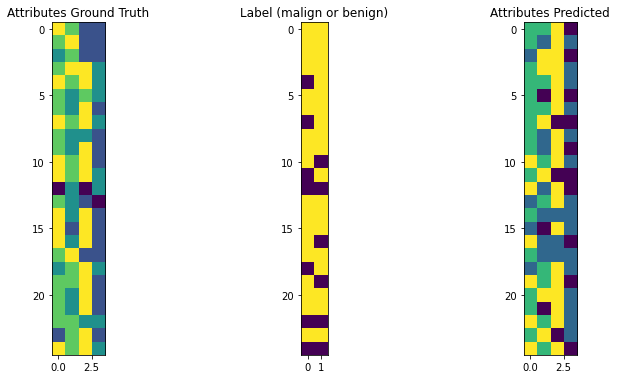

In [90]:
## ALL this should be on TEST set
# Visualizing the results for attributes and labels
attr_pred = attr_pred.reshape(-1, 4)
attr_gt = attr_gt.reshape(-1, 4)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)



ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
#ax2.imshow((attr_pred > 0.5) * 1)
#ax2.set_title("Attributes Predicted and Thresholded")

ax2.imshow(viz)
ax2.set_title("Label (malign or benign)")

#ax4.imshow(attr_gt)
#ax4.set_title("Attributes Ground Truth")
ax3.imshow(attr_pred )
ax3.set_title("Attributes Predicted")

#ax6.imshow(viz)
#ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

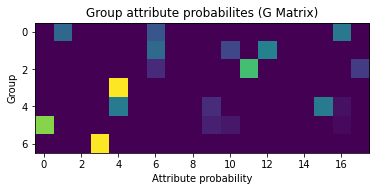

In [91]:
# Visualizing G matrix
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

Text(0.5, 0, 'W values')

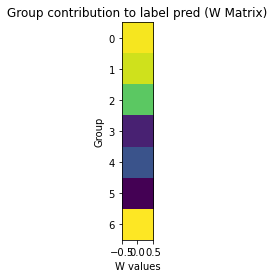

In [92]:
# Visualizing W Matrix
plt.imshow(model.W_.data.detach().cpu().numpy())
plt.title("Group contribution to label pred (W Matrix)")
plt.ylabel("Group")
plt.xlabel("W values")

In [93]:
# Legacy CAM code
# class CamExtractor():
#     """
#         Extracts cam features from the model
#     """
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
        

#     def forward_pass_on_convolutions(self, x):
#         """
#             Does a forward pass on convolutions, hooks the function at given layer
#         """
#         conv_output = None
#         module_pos = 1
#         for module in self.model.features:
#             x = model.pool(module(x))  # Forward
#             if int(module_pos) == self.target_layer:
#                 conv_output = x  # Save the convolution output on that layer
#             module_pos += 1
#         return conv_output, x

#     def forward_pass(self, x):
#         """
#             Does a full forward pass on the model
#         """
#         conv_output, _ = self.forward_pass_on_convolutions(x)
#         x = F.interpolate(x, (300, 300), mode='bilinear')
#         (x_, _) = model(x)
#         return conv_output, x_

    
# extractor = CamExtractor(model, 4)

# count = 0
# for data in test_generator:
#     y_im_test = data["labels"][:, 15].to(device)
#     x_im_test = data["image"]
#     x_im_test = x_im_test.to(device)


#     [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
#     target = conv_out
#     cam = np.ones((target.shape[1:]), dtype=np.float32)
#     sal_map = np.zeros((224, 224))
#     for i in range(np.shape(target)[1]):
#                 # Unsqueeze to 4D
#                 saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
#                 # Upsampling to input size
#                 saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
#                 if saliency_map.max() == saliency_map.min():
#                     continue
#                 # Scale between 0-1
#                 norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
#                 inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
#                 w = extractor.forward_pass(inim * norm_saliency_map)[1]
#                 sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
#                 cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


#     fig = plt.figure(figsize=(15, 10))

#     ax0 = fig.add_subplot(131)
#     ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

#     ax1 = fig.add_subplot(132)
#     ax1.imshow(sal_map)

#     ax2 = fig.add_subplot(133)
#     ax2.imshow(cam[0, :, :])
#     count += 1
#     if(count == 10):
#         break


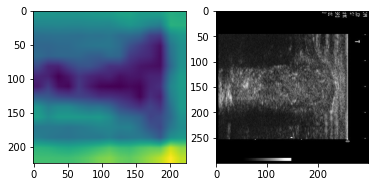

In [56]:
# Legacy CAM code
# fig = plt.figure()
# ax0 = fig.add_subplot(121)
# ax0.imshow(sal_map)

# ax1 = fig.add_subplot(122)
# ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [94]:
#Sankey plot code for G matrix
source = [i % a for i in range(z*a)]
target = [(i // a) + a for i in range(z*a)]
G[G < 0.1] = 0.0
value = G.flatten().tolist()
#print(len(source), len(target), len(value))

# FIXME: Can we make this list depend on z and a?
color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080',
              '#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00'
              ]

color_link = []
link_colors = ['#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00']

In [95]:
for i in range(z):
    color_link.extend([link_colors[i]] * a)
#print(color_link)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      color = color_node,
      label = ["unknown comp", "cystic", "mostly solid", "solid", "spongiform",
               "unknown echo", "hyper", "hypo", "iso", "marked",
               "unknown margin", "ill-defined", "micro", "spiculated", "smooth",
               "macro", "micro", "non",
               "G1", "G2", "G3", "G4", "G5",
               "G6", "G7"],
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()